Transformer Decoder

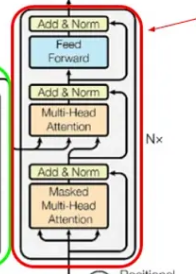

In [11]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F

## Setting The Hyperprameters

In [12]:
batch_size = 32
max_seq_len = 64
input_dim = 512
d_model = 512
num_heads = 8
ffn_hidden = 2048
num_layers = 6
dropout_rate = 0.2

## Multihead Self Attention

In [13]:
def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.size(-1)
    qk = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None and mask is True:
        mask = torch.full(qk.size(),fill_value= float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        qk = qk + mask 
    qk = F.softmax(qk, dim=-1)
    new_qkv = torch.matmul(qk, v)
    return new_qkv

class Multihead_Self_Attention(nn.Module):
    def __init__(self,input_dim, d_model, num_heads):
        super(Multihead_Self_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = d_model
        self.num_heads = num_heads
        self.head_dim = self.model_dim // self.num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * self.model_dim)
        self.concat_layer = nn.Linear(self.model_dim, self.model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,mask=None):
        qkv = self.qkv_layer(x)
        qkv = qkv.view(batch_size,max_seq_len,self.num_heads,3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q,k,v = qkv.chunk(3,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.view(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Multihead Cross Attention

In [14]:
class Multihead_Cross_Attention(nn.Module):
    def __init__(self,input_dim, model_dim, num_heads):
        super(Multihead_Cross_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.qk_layer = nn.Linear(input_dim, 2 * model_dim)
        self.v_layer = nn.Linear(input_dim, model_dim)
        self.concat_layer = nn.Linear(model_dim, model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,y,mask=None):
        qk = self.qk_layer(x)
        v = self.v_layer(y)
        qk = qk.view(batch_size,max_seq_len,num_heads,2*self.head_dim)
        v = v.view(batch_size,max_seq_len,num_heads,self.head_dim)
        qk = qk.permute(0,2,1,3)
        v = v.permute(0,2,1,3)
        q,k = qk.chunk(2,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.view(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Positional Encoding

In [15]:
class PostionalEncoding(nn.Module):
    def __init__(self,max_seq_len,d_model):
        super(PostionalEncoding,self).__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.encoding = torch.zeros(self.max_seq_len,self.d_model)
    
    def forward(self,x):
        even_index = torch.arange(0,self.d_model,2).float()
        domenator = torch.pow(10000,even_index/self.d_model)
        position = torch.arange(0,self.max_seq_len).unsqueeze(1)
        PE_even = torch.sin(position/domenator)
        PE_odd = torch.cos(position/domenator)
        stacked = torch.stack([PE_even,PE_odd],dim=2)
        PE_flatten = torch.flatten(stacked,start_dim=1,end_dim=2)
        return PE_flatten

## Normalization Layer

In [16]:
class NormalizationLayer(nn.Module):
    def __init__(self, parameter_dim):
        super(NormalizationLayer, self).__init__()
        self.parameters_shape = parameter_dim
        self.gamma = nn.Parameter(torch.ones(parameter_dim))
        self.beta = nn.Parameter(torch.zeros(parameter_dim))
        self.eps = 1e-6

    def forward(self, x):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = x.mean(dims, keepdim=True)
        std = x.std(dims, keepdim=True)
        out = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return out

## Position-wise Feed-Forward

In [17]:
class FeedForward(nn.Module):
    def __init__(self,d_model,ffn_hidden):
        super(FeedForward,self).__init__()
        self.d_model = d_model
        self.ffn_hidden = ffn_hidden
        self.layer1 = nn.Linear(self.d_model,self.ffn_hidden)
        self.layer2 = nn.Linear(self.ffn_hidden,self.d_model)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

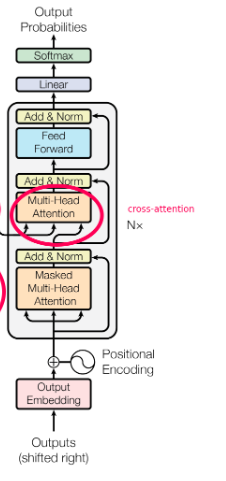

In [18]:
class Decoder_Layer(nn.Module):
    def __init__(self,num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate):
        super(Decoder_Layer,self).__init__()
        self.multihead_self_attention = Multihead_Self_Attention(input_dim,d_model,num_heads)
        self.multihead_cross_attention = Multihead_Cross_Attention(input_dim,d_model,num_heads)
        self.feedforward = FeedForward(d_model,ffn_hidden)
        self.norm1 = NormalizationLayer([d_model])
        self.norm2 = NormalizationLayer([d_model])
        self.norm3 = NormalizationLayer([d_model])
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)
    
    def forward(self, x, y):
        reseduial_y = y
        y = self.multihead_self_attention(y,mask = True)
        y = self.dropout1(y)
        y = y + reseduial_y
        y = self.norm1(y)

        reseduial_y = y
        y = self.multihead_cross_attention(x,y)
        y = self.dropout2(y)
        y = y + reseduial_y
        y = self.norm2(y)

        reseduial_y = y
        y = self.feedforward(y)
        y = self.dropout3(y)
        y = y + reseduial_y
        y = self.norm3(y)

        return y

In [19]:
class Sequential_Decoder(nn.Sequential):
    def forward(self,*input):
        x, y = input
        for module in self._modules.values():
            y = module(x, y) 
        return y


In [20]:
class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers):
        super().__init__()
        self.layers = Sequential_Decoder(*[Decoder_Layer(num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate)
                                     for _ in range(num_layers)])
    def forward(self, x, y):
        y = self.layers(x, y)
        return y

In [21]:
x = torch.randn(batch_size,max_seq_len,input_dim)
y = torch.randn(batch_size,max_seq_len,input_dim)
encoder = Decoder(d_model, ffn_hidden, num_heads, dropout_rate, num_layers)
out = encoder(x,y)
print(out.shape)
out

torch.Size([32, 64, 512])


tensor([[[ 9.8291e-01,  9.3484e-01,  2.2851e-01,  ...,  2.6624e-01,
          -1.3264e+00,  2.2067e+00],
         [-3.6825e-01,  1.5494e-01,  7.9998e-01,  ...,  9.0474e-02,
          -1.2983e+00,  1.8181e+00],
         [ 1.5303e+00,  1.4860e+00,  3.5075e-01,  ..., -5.4753e-01,
          -7.2854e-01,  7.7258e-01],
         ...,
         [-6.2196e-01, -8.5410e-01, -1.0732e+00,  ..., -1.5126e+00,
          -2.1567e-03,  3.3180e-01],
         [-1.1086e+00,  3.7750e-01,  4.1111e-01,  ..., -3.3683e-01,
           1.9879e+00,  6.4326e-01],
         [-5.3316e-01, -1.0547e-01, -2.6561e-02,  ...,  8.4335e-01,
          -9.4392e-01,  1.3791e+00]],

        [[-1.4908e+00, -2.3166e+00, -2.5186e-01,  ..., -1.2198e+00,
          -1.9377e+00,  7.9837e-01],
         [-3.4438e-01, -3.2537e-01, -1.1908e-01,  ..., -7.0410e-01,
          -2.5697e+00,  4.6258e-01],
         [-1.8177e-01, -1.3547e-01, -2.5722e-01,  ...,  7.0306e-01,
          -2.2608e-01,  7.0609e-01],
         ...,
         [ 6.4853e-01, -8